# <a href="https://mipt-stats.gitlab.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Профильное задание №1 для направления "физика"

**Правила:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`.
* Дедлайн **15 мая в 23:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb` и все фотографии, если пишете теоретическую часть от руки.
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него.

-----



In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Задача 1 Оптимизационная

Физики из города Долгопрудный купили сверхточный термометр и датчик давления для исследования разреженных газов. В сосуд с изменяемым объемом они закачали некоторое количество одноатомного газа, причем он оказался достаточно разреженным. Затем они изменяли температуру данного сосуда и измеряли давление, причём теплоемкость газа в данном процессе можно считать постоянной. Значения, полученные в ходе эксперимента, они записывали в этот [файл](https://drive.google.com/file/d/1vg3fFktL01uqXNjUFRxlDdYWOyHOjDJL/view?usp=sharing). Постройте оценку теплоёмкости данного газа с как можно меньшей погрешностью. 

Оценка должна быть "адекватной" (константа не подойдет :) ). Понятие адекватности определяйте сами.

*Указание 1: для процессов с постоянной теплоёмкостью зависимость давления от температуры имеет вид $P \propto T^{\alpha}$, где $\alpha$ &mdash; любое число.*

*Указание 2: Может быть полезным для уменьшения погрешности усреднять давление в некотором диапазоне температур.*




Термодинамическое уравнение (все пишу без азмерностей, так как важен общий вид зависимости, а не размерные коэф-ы):

$C dT = C_V dT + P dV$

$V = T/P$

$C dT = C_V dT + dT - \frac{dP T}{P}$

$C_P = C_V + 1$

$\ln{P} = (C_P - C) \ln{T}$

$P \propto T^{C_P - C}$

Если добавить размерности, то получится:

$P \propto T^{(C_P - C)/\nu R}$

In [16]:
df = pd.read_csv("task1.txt", sep=' ', names=["T", "P"], skiprows=1)
print(df.head(20))
print(df.describe())

         T    P
0   200.05  100
1   200.10  112
2   200.15   98
3   200.20   90
4   200.25  108
5   200.30  111
6   200.35  124
7   200.40   97
8   200.45   95
9   200.50  109
10  200.55  106
11  200.60  105
12  200.65  105
13  200.70  111
14  200.75  104
15  200.80  113
16  200.85  107
17  200.90   79
18  200.95  110
19  201.00   85
                  T             P
count  10000.000000  10000.000000
mean     450.025000    558.607800
std      144.344784    329.208257
min      200.050000     79.000000
25%      325.037500    263.000000
50%      450.025000    506.000000
75%      575.012500    826.000000
max      700.000000   1315.000000


Так как измерения давления, видимо, производятся не очень точно, то в пределах 0,5 градусов по температуре давление сильно отклоняется от некотого среднего. Поэтому усредним значения по корзинам, в каждой из которых значения P в пределах 0,5 по T. 

In [22]:
data_frame = df.groupby(df["T"]//0.5, as_index=False).mean()
data_frame.head(20)

,T,P
0,200.250,103.888889
1,200.725,104.900000
2,201.225,104.200000
3,201.725,107.100000
4,202.225,105.900000
5,202.725,106.700000
6,203.225,103.900000
7,203.725,103.300000
8,204.225,106.100000
9,204.725,104.900000


Построим график данных после усреднения внутри небольшого диапозона температур

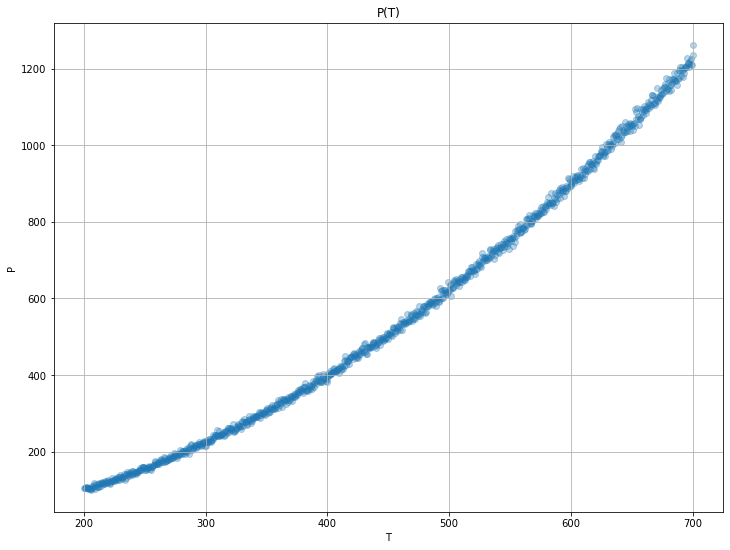

In [30]:
plt.figure(figsize=(12, 9))
plt.title("P(T)")
plt.scatter(data_frame["T"], data_frame["P"], alpha=0.3)
plt.grid(True)
plt.xlabel("T")
plt.ylabel("P")
plt.show()

Исходя из степенного вида зависимости, коэф $\alpha$ будем искать с помощью логарифмического масштаба.

$\ln{P} = \alpha \ln{T} + const$

In [28]:
data_frame["lnT"] = np.log(data_frame["T"])
data_frame["lnP"] = np.log(data_frame["P"])

Воспользуемся методом линейной регрессии, для этого надо разделить наши данные на тренировочную и тестовую часть (буду делить в соотношении 8/2).

In [60]:
lnT_train, lnT_test, lnP_train, lnP_test = train_test_split(data_frame["lnT"], data_frame["lnP"], test_size=0.2, shuffle=True)
model = LinearRegression(fit_intercept=True) 
model_trained = model.fit(np.array([lnT_train]).T, np.array([lnP_train]).T )
alpha = model_trained.coef_[0][0]
intercept = model_trained.intercept_[0]
print("alpha:", alpha)

alpha: 1.999796971224568


Построим на одном графике данные и фитирующую прямую

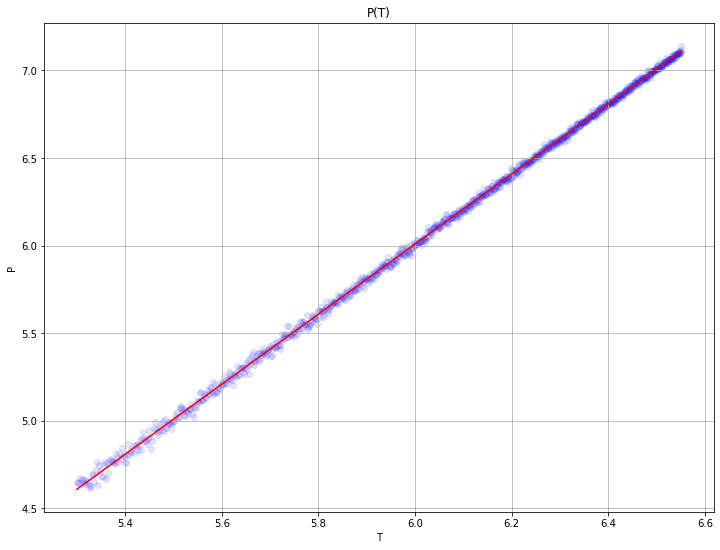

In [61]:
plt.figure(figsize=(12, 9))
plt.title("P(T)")
plt.scatter(data_frame["lnT"], data_frame["lnP"], alpha=0.1, color="blue")
linspace = np.linspace(data_frame["lnT"].min(), data_frame["lnT"].max(), 10)
plt.plot(linspace, alpha*linspace+intercept, color="red")
plt.grid(True)
plt.xlabel("T")
plt.ylabel("P")
plt.show()

Посчитаю абсолютную процентную погрешность

In [69]:
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(np.array([lnP_test]).T, 
                                                               model_trained.predict(np.array([lnT_test]).T)))

MAPE:  0.002234558608936687


**Вывод:** По графику видно, что фитирующая прямая очень хорошо ложится на логарифмические данные (MAPE < 0.003 %). Значит этой оценке можно доверять. Значит, $C = -1.999 R + C_P = R (-1.999 + 5/2) = 0.501 R$ 

# Задача 2
В сфере статистики экзопланет ныне бытует мнение, что чем выше металличность звезды, тем выше вероятность того, что у нее будет планета гигант. Рассмотрим [часть выгрузки](https://drive.google.com/file/d/1PTc_AXsRogXQj_4paxbWWqxX5NWZJQoS/view) базы данных экзопланетного архива NASA и проверим, так ли это. Конечно, в реальном исследовании стоит учитывать неоднородность данных, но для начала нам будет достаточно и сырых данных.

Проверьте гипотезу с использованием критерия согласия хи-квадрат. 

*Замечание: в этой задаче у вас есть шанс поработать с настоящими "реальными" данными:)*


In [72]:
import pandas as pd

data = pd.read_csv("task - Anastasiia Ivanova.csv", sep = ';')
data.head(20)

,pl_name,hostname,discoverymethod,pl_bmassj,st_spectype,st_met,st_metratio,If planet mass>0.3 1; else,If metal>0 1; else 0,Unnamed: 9,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,61 Vir b,61 Vir,Radial Velocity,"0,01600",G5 V,"-0,010",[Fe/H],0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61 Vir c,61 Vir,Radial Velocity,"0,05700",G5 V,"-0,010",[Fe/H],0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61 Vir d,61 Vir,Radial Velocity,"0,07200",G5 V,"-0,010",[Fe/H],0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24 Sex b,24 Sex,Radial Velocity,"1,99000",NaN,"-0,030",[Fe/H],1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24 Sex c,24 Sex,Radial Velocity,"0,86000",NaN,"-0,030",[Fe/H],1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,91 Aqr b,91 Aqr,Radial Velocity,"3,20000",K0 III,"-0,030",[Fe/H],1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BD-17 63 b,BD-17 63,Radial Velocity,"5,10000",K5 V,"-0,030",[Fe/H],1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,CoRoT-11 b,CoRoT-11,Transit,"2,34000",NaN,"-0,030",[Fe/H],1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Kepler-117 b,Kepler-117,Transit,"0,09400",F8 V,"-0,040",[Fe/H],0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Kepler-117 c,Kepler-117,Transit,"1,84000",F8 V,"-0,040",[Fe/H],1,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Нам нужны колонки "If planet mass>0.3 1; else" и "If metal>0 1; else 0"

In [73]:
data_new = data[['If planet mass>0.3 1; else', 'If metal>0 1; else 0']].dropna()


data_new.head(20)

,If planet mass>0.3 1; else,If metal>0 1; else 0
0,0,0
1,0,0
2,0,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,0,0
9,1,0


Посчитаем количество планет с массой больше или меньше 0,3 и 0,1, чтобы применить критерий хи-квадрат

In [77]:
n1 = data_new[data_new['If planet mass>0.3 1; else'] == 1][data_new['If metal>0 1; else 0'] == 1].shape[0]
n2 = data_new[data_new['If metal>0 1; else 0'] == 0][data_new['If planet mass>0.3 1; else'] == 1].shape[0]
n3 = data_new[data_new['If metal>0 1; else 0'] == 1][data_new['If planet mass>0.3 1; else'] == 0].shape[0]
n4 = data_new[data_new['If metal>0 1; else 0'] == 0][data_new['If planet mass>0.3 1; else'] == 0].shape[0]

<ipython-input-77-ed9fc3b318ce>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = data_new[data_new['If planet mass>0.3 1; else'] == 1][data_new['If metal>0 1; else 0'] == 1].shape[0]
<ipython-input-77-ed9fc3b318ce>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = data_new[data_new['If metal>0 1; else 0'] == 0][data_new['If planet mass>0.3 1; else'] == 1].shape[0]
<ipython-input-77-ed9fc3b318ce>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = data_new[data_new['If metal>0 1; else 0'] == 1][data_new['If planet mass>0.3 1; else'] == 0].shape[0]
<ipython-input-77-ed9fc3b318ce>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n4 = data_new[data_new['If metal>0 1; else 0'] == 0][data_new['If planet mass>0.3 1; else'] == 0].shape[0]


In [82]:
data_chi_2 = chi2_data = [[n1, n2], [n3, n4]]

chi_2 = sps.chi2_contingency(data_chi_2, correction=False)
print("хи-квадрат:", chi_2[0])
print("p-value:", chi_2[1])

хи-квадрат: 3.9829151519500225
p-value: 0.04596394954925494


**Вывод:**

Видно, что p-value = 0.045 < 0.05. Значит, на уровне значимости 0,05 мы отвергаем гипотезу о том, что взаимосвязи нет в пользу альтернативы о существовании взаимосзязи металличности планеты и вероятности нахождения планеты гиганта.